<a href="https://colab.research.google.com/github/plaban1981/POCs/blob/main/Text_Extraction_from_a_Table_Image%2C_using_PyTesseract_and_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Extraction from a Table Image, using PyTesseract and OpenCV

## Install Dependencies

In [1]:
! sudo apt-get update
! sudo apt-get install libleptonica-dev 
! sudo apt-get install tesseract-ocr 
! sudo apt-get install tesseract-ocr-dev
! sudo apt-get install libtesseract-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.9 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [581 kB]
Hit:14 http://ppa.launchpad.net/cran/libgit2/ubuntu bion

In [23]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=2bafbd778abcaa10a2aad8877703b0156a61bc0cbd9cc87a9204440d9c35535f
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


## Install Tabula

In [2]:
!pip install tabula-py

     |████████████████████████████████| 12.0 MB 8.0 MB/s 


## Mount Drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Load the image

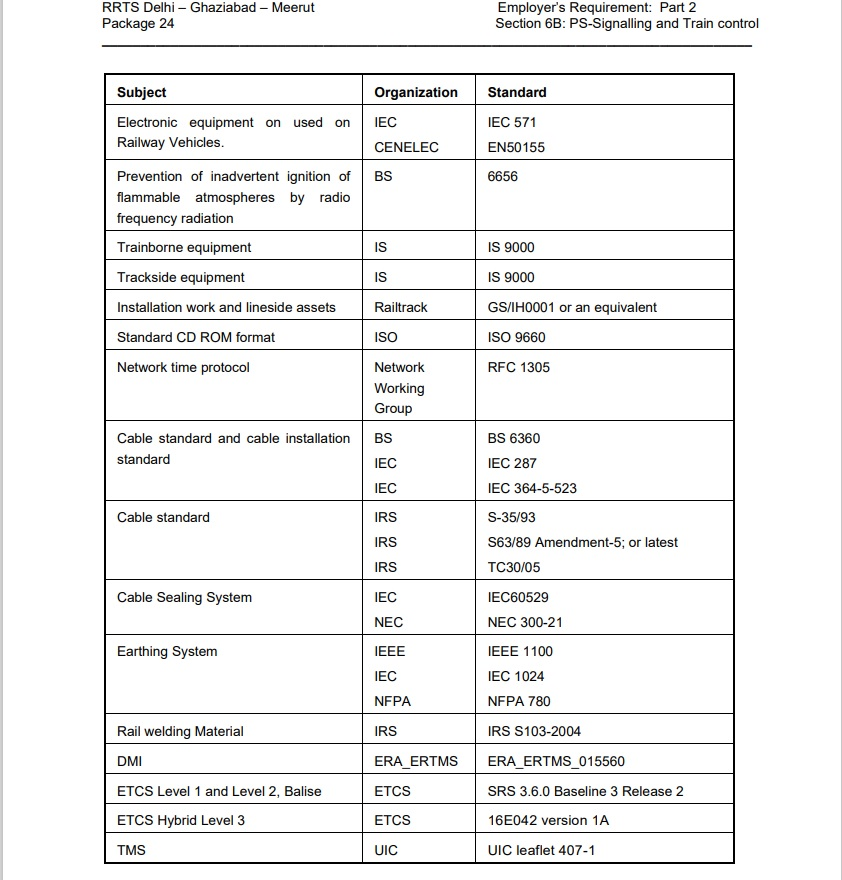

In [197]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

filename = '/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0006.jpg'
img = cv.imread(cv.samples.findFile(filename))
cImage = np.copy(img) #image to draw lines
cv2_imshow(img) #name the window as "image"


## Cells Detection

* Finding horizontal and vertical lines within a table might be the easiest to start withn by applying applying the **Hough Line Transform**.

#### preprocess

* The first one is to convert your image into a gray scale image, in case you have an RGB image.
 
* This gray scale image is important for the next step, Canny Edge-Detection.

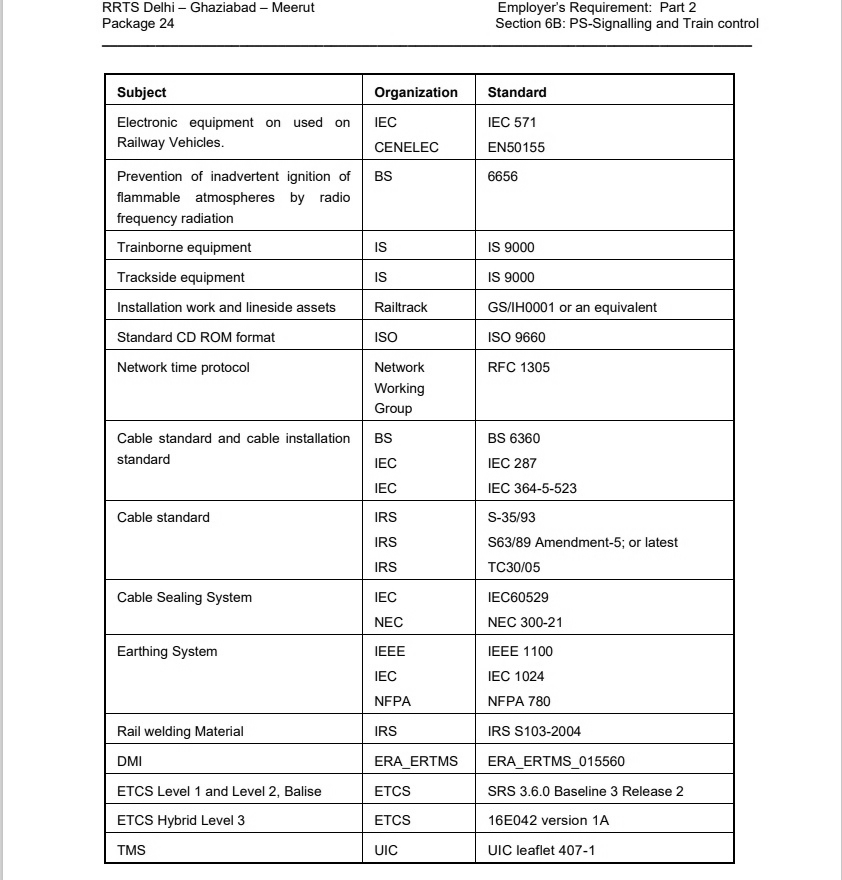

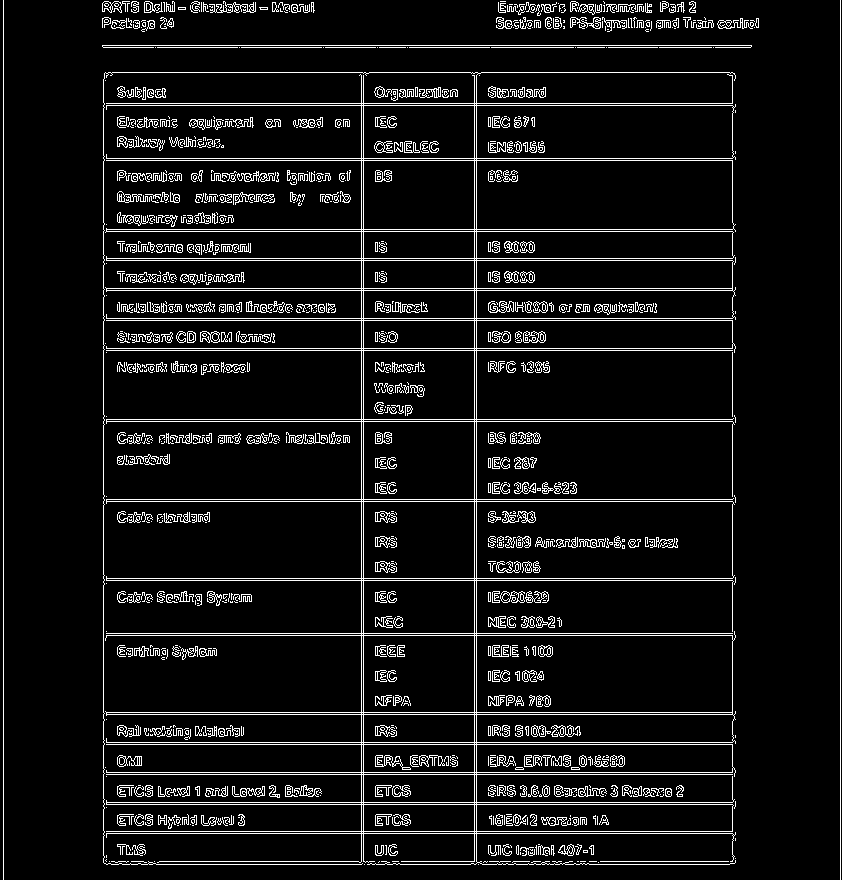

In [198]:
import matplotlib.pyplot as plt
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
cv2_imshow(gray)
canny = cv.Canny(gray, 50, 150)
cv2_imshow(canny)

## Hough Line Transform

* In OpenCV, there are two types of this algorithm, 
 * standard Hough Line Transform and      
 * probabilistic Hough Line Transform. 
    
* The standard one will give you the line equation, so you do not know the beginning and end of the line. 

* While the probabilistic line transform will give you the list of lines, in which a line is a list of the beginning and end coordinate.The probabilistic one is more preferable.

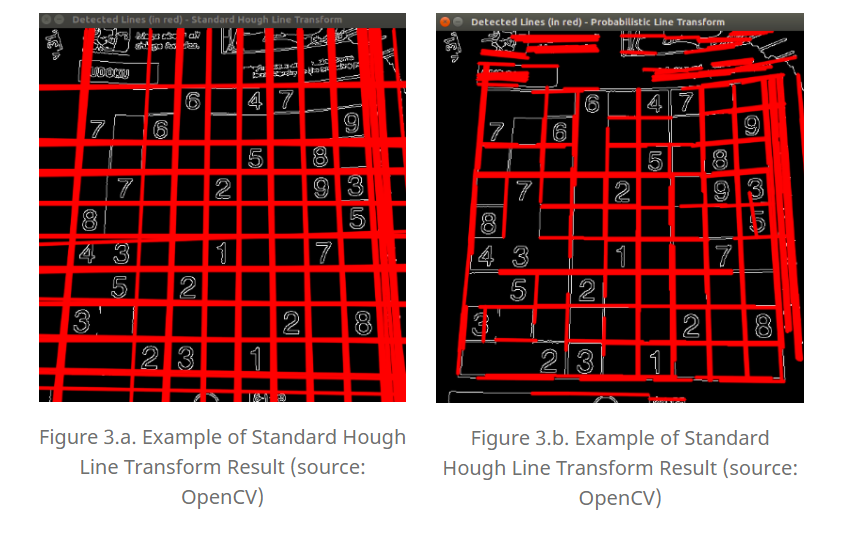

## Arguements for  HoughLines Probability  function:

* image — 8-bit, single-channel binary source image. The image may be modified by the function.
* rho — Distance resolution of the accumulator in pixels.
* theta — Angle resolution of the accumulator in radians.
* threshold — Accumulator threshold parameter. Only those lines are returned that get enough votes
* line — Output vector of lines. Here is set to None, the value is saved to linesP
* minLineLength — Minimum line length. Line segments shorter than that are rejected.
* maxLineGap — Maximum allowed gap between points on the same line to link them.

In [199]:
# cv.HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]) → lines
rho = 1
theta = np.pi/180
threshold = 50
minLinLength = 350
maxLineGap = 6
linesP = cv.HoughLinesP(canny, rho , theta, threshold, None, minLinLength, maxLineGap)

In [200]:
linesP.shape

(45, 1, 4)

## Function to differentiate between a horizontal and vertical line

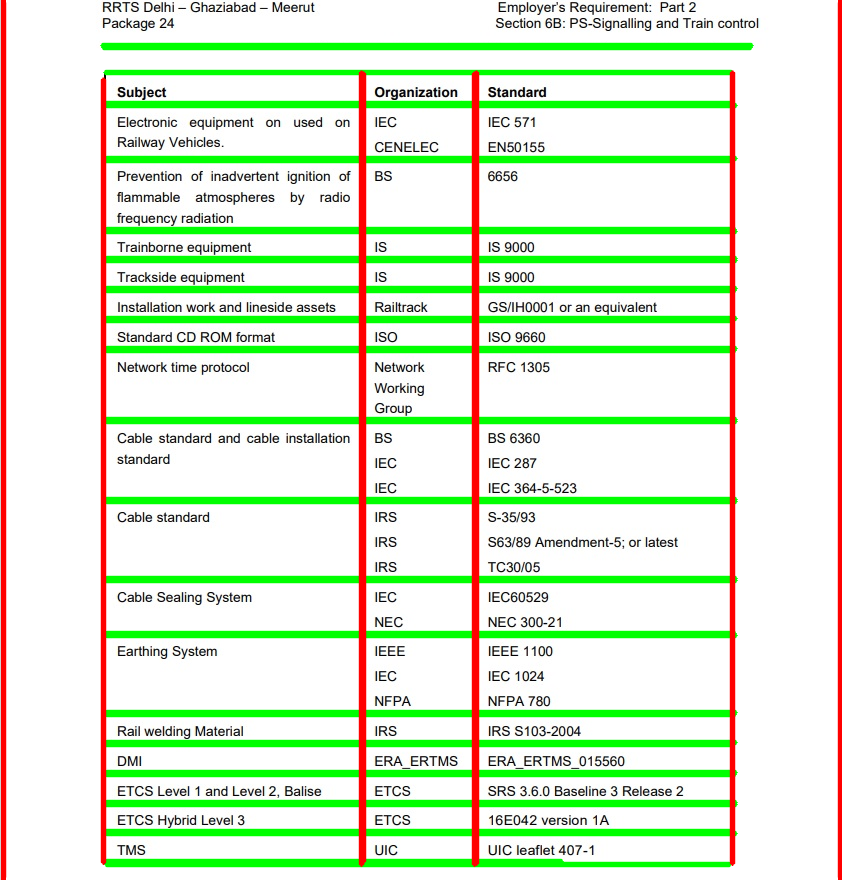

In [201]:
def is_vertical(line):
    return line[0]==line[2]

def is_horizontal(line):
    return line[1]==line[3]
    
horizontal_lines = []
vertical_lines = []
    
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]        
        if (is_vertical(l)):
            vertical_lines.append(l)
                
        elif (is_horizontal(l)):
            horizontal_lines.append(l)
for i, line in enumerate(horizontal_lines):
  cv.line(cImage, (line[0], line[1]), (line[2], line[3]), (0,255,0), 3, cv.LINE_AA)
                      
for i, line in enumerate(vertical_lines):
  cv.line(cImage, (line[0], line[1]), (line[2], line[3]), (0,0,255), 3, cv.LINE_AA)
            
cv2_imshow(cImage)

## Overlap Filter

There are some overlapping lines in the Hough Line Transform result. The thicker lines consist of more than a line in the same position, different in length. To eliminate this overlapping line, I define an overlapping filter.

In [202]:
def overlapping_filter(lines, sorting_index):
    filtered_lines = []
    
    lines = sorted(lines, key=lambda lines: lines[sorting_index])
    separation = 5    
    for i in range(len(lines)):
            l_curr = lines[i]
            if(i>0):
                l_prev = lines[i-1]
                if ( (l_curr[sorting_index] - l_prev[sorting_index]) > separation):
                    filtered_lines.append(l_curr)
            else:
                filtered_lines.append(l_curr)
                
    return filtered_lines

## Implementing the overlapping filter and adding text on the image

[array([840, 879, 840,   0], dtype=int32), array([476, 863, 476,  72], dtype=int32), array([  3, 879,   3,   0], dtype=int32), array([103, 862, 103,  79], dtype=int32), array([474, 864, 474,  73], dtype=int32), array([361, 864, 361,  72], dtype=int32), array([732, 863, 732,  72], dtype=int32), array([363, 861, 363,  73], dtype=int32)]
[array([104, 499, 735, 499], dtype=int32), array([104, 831, 731, 831], dtype=int32), array([106, 231, 735, 231], dtype=int32), array([106, 348, 735, 348], dtype=int32), array([106, 318, 735, 318], dtype=int32), array([106, 229, 734, 229], dtype=int32), array([106, 350, 734, 350], dtype=int32), array([106, 501, 735, 501], dtype=int32), array([106, 578, 735, 578], dtype=int32), array([106, 864, 729, 864], dtype=int32), array([106, 714, 734, 714], dtype=int32), array([102,  45, 751,  45], dtype=int32), array([106, 772, 735, 772], dtype=int32), array([106, 105, 735, 105], dtype=int32), array([105,  72, 731,  72], dtype=int32), array([104, 160, 731, 160], dtyp

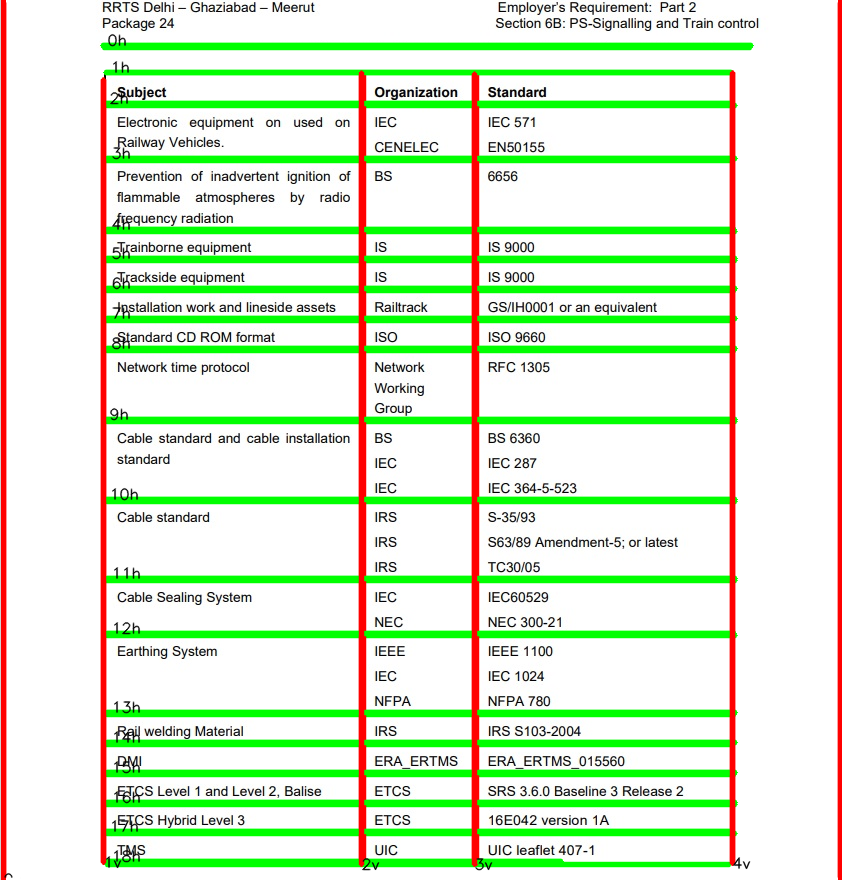

In [203]:
horizontal_lines = []
vertical_lines = []
    
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]        
        if (is_vertical(l)): 
            vertical_lines.append(l)
                
        elif (is_horizontal(l)):
            horizontal_lines.append(l)   
    print(vertical_lines)
    print(horizontal_lines) 
    horizontal_lines = overlapping_filter(horizontal_lines, 1)
    vertical_lines = overlapping_filter(vertical_lines, 0)
    for i, line in enumerate(horizontal_lines):
      cv.line(cImage, (line[0], line[1]), (line[2], line[3]), (0,255,0), 3, cv.LINE_AA)
      cv.putText(cImage, str(i) + "h", (line[0] + 5, line[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)                      
    for i, line in enumerate(vertical_lines):
      cv.line(cImage, (line[0], line[1]), (line[2], line[3]), (0,0,255), 3, cv.LINE_AA)
      cv.putText(cImage, str(i) + "v", (line[0], line[1] + 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)            
cv2_imshow( cImage)

## ROI Selection

First of all, we need to define the number of columns and rows. In my case, 

* Here we are interested in data from row tweleve to  20, and all the columns. 

* For the columns, I defined a list named keywords to use it for the dictionary keyword.

In [204]:
## set keywords
keywords = ['Subject', 'Organization', 'Standard']
    
dict_keywords = {}
for keyword in keywords:
  dict_keywords[keyword] = []
        
## set counter for image indexing
counter = 0
    
## set line index
first_line_index = 2
last_line_index = 18

In [205]:
def get_cropped_image(image, x, y, w, h):
    cropped_image = image[ y:y+h , x:x+w ]
    return cropped_image
def get_ROI(image, horizontal, vertical, left_line_index, right_line_index, top_line_index, bottom_line_index, offset=1):
    x1 = vertical[left_line_index][2] + offset
    y1 = horizontal[top_line_index][3] + offset
    x2 = vertical[right_line_index][2] - offset
    y2 = horizontal[bottom_line_index][3] - offset
    
    w = x2 - x1
    h = y2 - y1
    
    cropped_image = get_cropped_image(image, x1, y1, w, h)
    
    return cropped_image, (x1, y1, w, h)

https://fazlurnu.com/2020/06/23/text-extraction-from-a-table-image-using-pytesseract-and-opencv/

In [209]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'
def draw_text(src, x, y, w, h, text):
    cFrame = np.copy(src)
    cv.rectangle(cFrame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv.putText(cFrame, "text: " + text, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5, cv.LINE_AA)
    
    return cFrame
def detect(cropped_frame, is_number = False):
    if (is_number):
        text = pytesseract.image_to_string(cropped_frame,lang='eng',
                                           config ='-c tessedit_char_whitelist=0123456789 --psm 10 --oem 2')
    else:
        text = pytesseract.image_to_string(cropped_frame, config='--psm 10')        
        
    return text

## Convert the image to black and white for a better result 

In [210]:
counter = 0
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)
print("Start detecting text...")
(thresh, bw) = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)
for i in range(first_line_index, last_line_index):
    for j, keyword in enumerate(keywords):
        counter += 1
            
        left_line_index = j
        right_line_index = j+1
        top_line_index = i
        bottom_line_index = i+1
            
        cropped_image, (x,y,w,h) = get_ROI(bw, horizontal_lines, vertical_lines, left_line_index, right_line_index, top_line_index, bottom_line_index)
            
        if (keywords[j]=='S.No'):
           text = detect(cropped_image)
           dict_keywords[keyword].append(text)
         
        else:
            text = detect(cropped_image, is_number=True)
            dict_keywords[keyword].append(text)        
            image_with_text = draw_text(img, x, y, w, h, text)


Start detecting text...


TesseractError: ignored

In [33]:
vertical_lines[0]

array([  1, 880,   1,   1], dtype=int32)

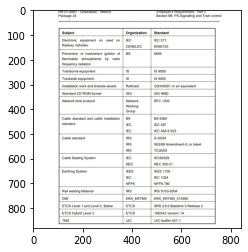

In [211]:
import cv2
import matplotlib.pyplot as plt
file='/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0006.jpg'
img = cv2.imread(file)
plot1 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Inverted Image with global thresh holding

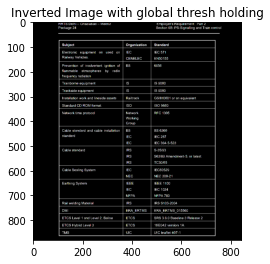

In [212]:
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
img_bin = 255-img_bin
plotting = plt.imshow(img_bin,cmap='gray')
plt.title("Inverted Image with global thresh holding")
plt.show()


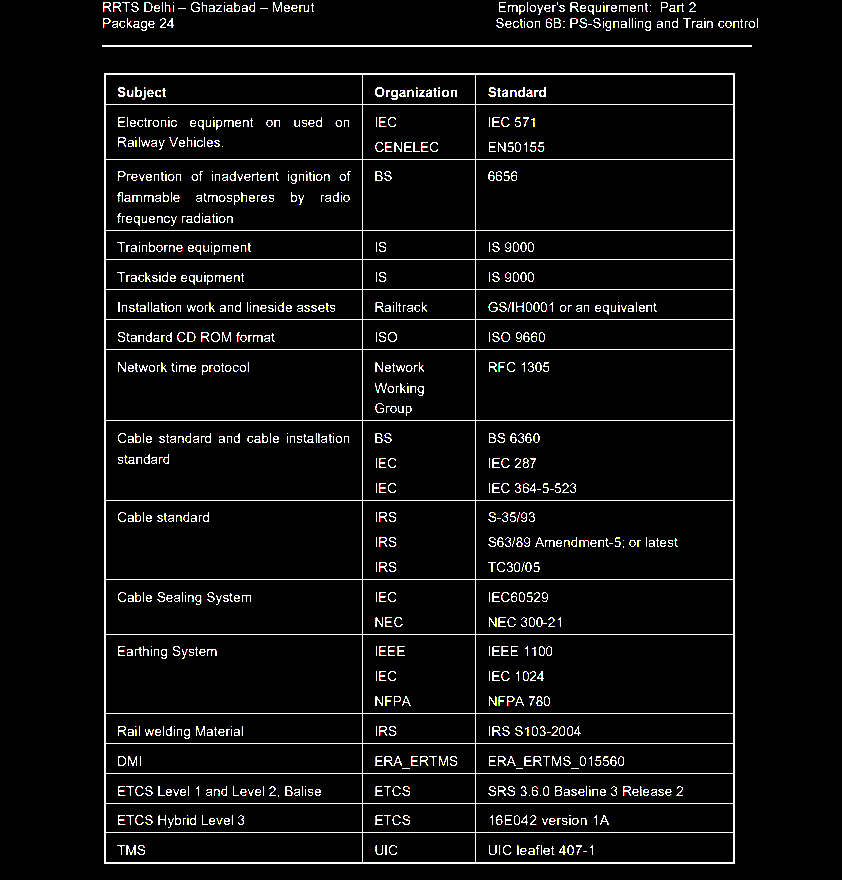

In [213]:
cv2_imshow(img_bin)

## Inverted Image with otsu thresh holding

* adaptive thresholding to an image that is not in greyscale. And the function only works with a greyscale images.

* resolve error"(-215:Assertion failed) src.type() == CV_8UC1 in function 'threshold" by converting images into gray scale

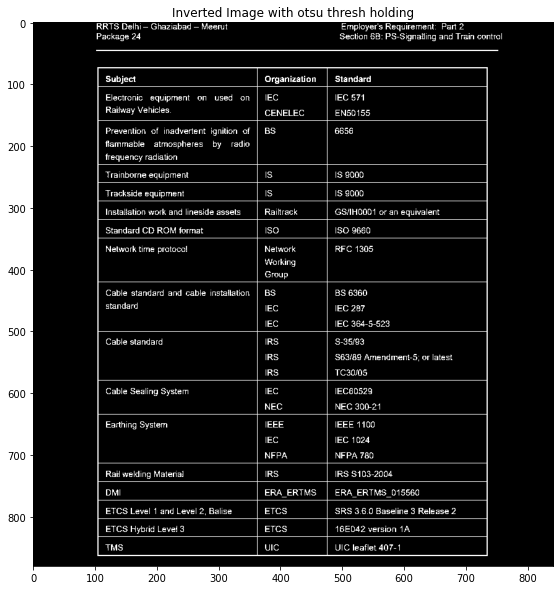

In [214]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_bin1 = 255-img_grey
thresh1,img_bin1_otsu = cv2.threshold(img_bin1,128,255,cv2.THRESH_OTSU)
plt.figure(figsize=(10,10))
plotting = plt.imshow(img_bin1_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

## Inverted image with both global and Otsu thresholding 

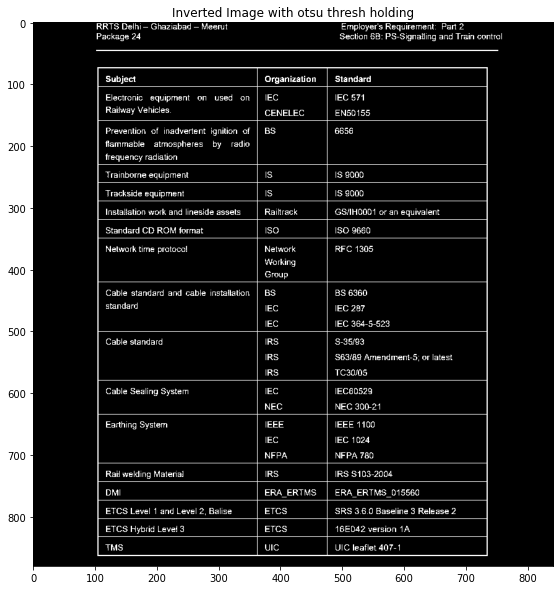

In [215]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_bin2 = 255-img_grey
thresh1,img_bin_otsu = cv2.threshold(img_bin2,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.figure(figsize=(12,10))
plotting = plt.imshow(img_bin_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

## Create a rectangular structuring element

In [216]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
print(kernel)

[[1 1]
 [1 1]]


## Morphological Operations
Create a new structuring element to perform erosion on the image
First we need to get the vertical lines.

We create a vertical kernel with kernel width 1 and height the number of columns in image array divided by 200.

Erosion makes the pixel 1 only if all the pixels under kernel are 1.

We perform erosion for 5 iterations with the vertical kernel.

In [62]:
np.array(img).shape[1]//100

7

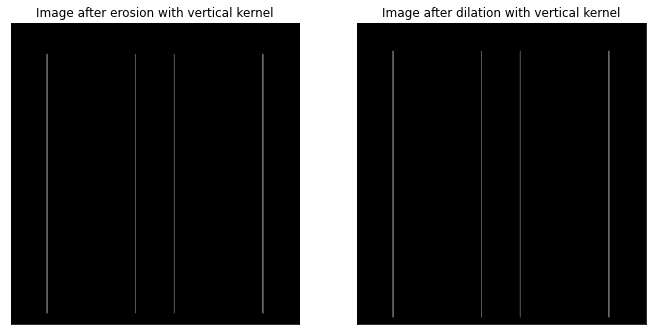

In [217]:
import numpy as np
plt.figure(figsize= (30,30))

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//100))
eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=5)
plt.subplot(151),plt.imshow(eroded_image, cmap = 'gray')
plt.title('Image after erosion with vertical kernel'), plt.xticks([]), plt.yticks([])

vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=3)
plt.subplot(152),plt.imshow(vertical_lines, cmap = 'gray')
plt.title('Image after dilation with vertical kernel'), plt.xticks([]), plt.yticks([])

plt.show()

* Dilation will make the pixel 1, if at least one of the pixels under the kernel is 1.

* Do the same for horizontal lines

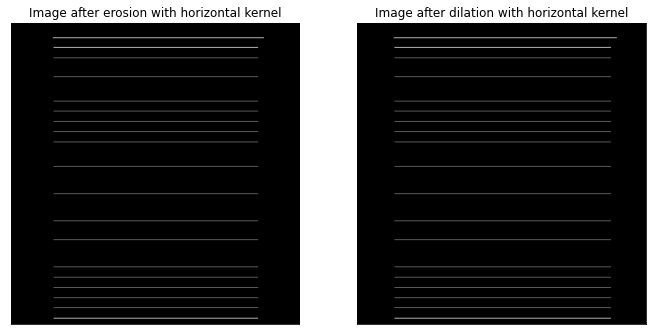

In [218]:
plt.figure(figsize= (30,30))

hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//100, 1))
horizontal_lines = cv2.erode(img_bin_otsu, hor_kernel, iterations=5)
plt.subplot(153),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after erosion with horizontal kernel'), plt.xticks([]), plt.yticks([])

horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=5)
plt.subplot(154),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after dilation with horizontal kernel'), plt.xticks([]), plt.yticks([])

plt.show()

## Now we add the two images

In [219]:
vertical_lines.shape

(880, 842)

In [220]:
horizontal_lines.shape

(880, 842)

In [221]:
img_grey.shape,vertical_horizontal_lines.shape

((880, 842), (881, 761))

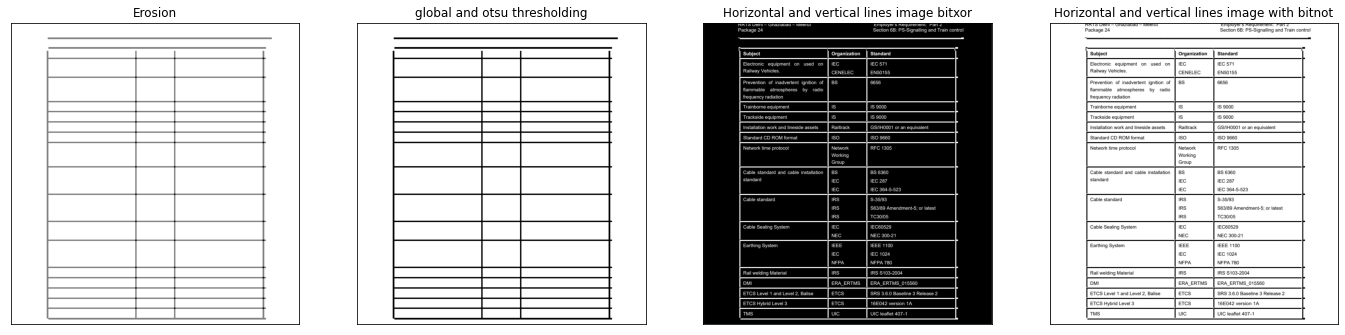

In [222]:
plt.figure(figsize= (30,30))

vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)
plt.subplot(151),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('Erosion'), plt.xticks([]), plt.yticks([])

thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.subplot(152),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('global and otsu thresholding'), plt.xticks([]), plt.yticks([])

bitxor = cv2.bitwise_xor(img_grey,vertical_horizontal_lines)
plt.subplot(153),plt.imshow(bitxor, cmap = 'gray')
plt.title('Horizontal and vertical lines image bitxor'), plt.xticks([]), plt.yticks([])

bitnot = cv2.bitwise_not(bitxor)
plt.subplot(154),plt.imshow(bitnot, cmap = 'gray')
plt.title('Horizontal and vertical lines image with bitnot'), plt.xticks([]), plt.yticks([])

plt.show()

## Get the contours get the contours from the grid that we have obtained by adding the horizontal and vertical lines

In [223]:
contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

## Bounding Boxes
To get the coordinates of different boxes

In [224]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
      reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
      i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')

In [225]:
boundingBoxes

((0, 0, 842, 880),
 (106, 44, 655, 7),
 (108, 72, 636, 7),
 (103, 83, 641, 785),
 (479, 108, 254, 51),
 (366, 108, 109, 51),
 (109, 108, 253, 51),
 (479, 163, 254, 67),
 (366, 163, 109, 67),
 (109, 163, 253, 67),
 (479, 234, 254, 25),
 (366, 234, 109, 25),
 (109, 234, 253, 25),
 (479, 263, 254, 26),
 (366, 263, 109, 26),
 (109, 263, 253, 26),
 (479, 293, 254, 26),
 (366, 293, 109, 26),
 (109, 293, 253, 26),
 (479, 323, 254, 26),
 (366, 323, 109, 26),
 (109, 323, 253, 26),
 (479, 353, 254, 67),
 (366, 353, 109, 67),
 (109, 353, 253, 67),
 (479, 424, 254, 76),
 (366, 424, 109, 76),
 (109, 424, 253, 76),
 (479, 504, 254, 75),
 (366, 504, 109, 75),
 (109, 504, 253, 75),
 (479, 583, 254, 51),
 (366, 583, 109, 51),
 (109, 583, 253, 51),
 (479, 638, 254, 75),
 (366, 638, 109, 75),
 (109, 638, 253, 75),
 (479, 717, 254, 26),
 (366, 717, 109, 26),
 (109, 717, 253, 26),
 (479, 747, 254, 26),
 (366, 747, 109, 26),
 (109, 747, 253, 26),
 (479, 777, 254, 26),
 (366, 777, 109, 26),
 (109, 777, 253, 

In [226]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

In [227]:
mean

72.32692307692308

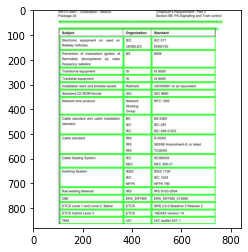

In [228]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [229]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[479, 717, 254, 26], [366, 717, 109, 26], [109, 717, 253, 26], [479, 747, 254, 26], [366, 747, 109, 26], [109, 747, 253, 26], [479, 777, 254, 26], [366, 777, 109, 26], [109, 777, 253, 26], [479, 807, 254, 25], [366, 807, 109, 25], [109, 807, 253, 25], [479, 836, 254, 26], [366, 836, 109, 26], [109, 836, 253, 26]]
[[[106, 44, 655, 7], [108, 72, 636, 7], [479, 108, 254, 51], [366, 108, 109, 51], [109, 108, 253, 51]], [[479, 163, 254, 67], [366, 163, 109, 67], [109, 163, 253, 67]], [[479, 234, 254, 25], [366, 234, 109, 25], [109, 234, 253, 25], [479, 263, 254, 26], [366, 263, 109, 26], [109, 263, 253, 26], [479, 293, 254, 26], [366, 293, 109, 26], [109, 293, 253, 26], [479, 323, 254, 26], [366, 323, 109, 26], [109, 323, 253, 26], [479, 353, 254, 67], [366, 353, 109, 67], [109, 353, 253, 67]], [[479, 424, 254, 76], [366, 424, 109, 76], [109, 424, 253, 76]], [[479, 504, 254, 75], [366, 504, 109, 75], [109, 504, 253, 75]], [[479, 583, 254, 51], [366, 583, 109, 51], [109, 583, 253, 51]], [[4

In [230]:
len(column),len(row),len(row[0]),len(row[1]),len(row[2])

(15, 8, 5, 3, 15)

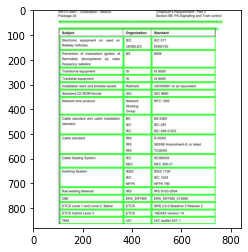

In [232]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [233]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[479, 717, 254, 26], [366, 717, 109, 26], [109, 717, 253, 26], [479, 747, 254, 26], [366, 747, 109, 26], [109, 747, 253, 26], [479, 777, 254, 26], [366, 777, 109, 26], [109, 777, 253, 26], [479, 807, 254, 25], [366, 807, 109, 25], [109, 807, 253, 25], [479, 836, 254, 26], [366, 836, 109, 26], [109, 836, 253, 26]]
[[[106, 44, 655, 7], [108, 72, 636, 7], [479, 108, 254, 51], [366, 108, 109, 51], [109, 108, 253, 51]], [[479, 163, 254, 67], [366, 163, 109, 67], [109, 163, 253, 67]], [[479, 234, 254, 25], [366, 234, 109, 25], [109, 234, 253, 25], [479, 263, 254, 26], [366, 263, 109, 26], [109, 263, 253, 26], [479, 293, 254, 26], [366, 293, 109, 26], [109, 293, 253, 26], [479, 323, 254, 26], [366, 323, 109, 26], [109, 323, 253, 26], [479, 353, 254, 67], [366, 353, 109, 67], [109, 353, 253, 67]], [[479, 424, 254, 76], [366, 424, 109, 76], [109, 424, 253, 76]], [[479, 504, 254, 75], [366, 504, 109, 75], [109, 504, 253, 75]], [[479, 583, 254, 51], [366, 583, 109, 51], [109, 583, 253, 51]], [[4

In [235]:
len(column),len(row)

(15, 8)

In [234]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol
countcol

15

In [236]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [237]:
center

array([235, 235, 235, 235, 235, 420, 420, 420, 420, 420, 606, 606, 606,
       606, 606])

In [238]:
len(column),len(row),countcol

(15, 8, 15)

In [239]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [240]:
finalboxes

[[[[106, 44, 655, 7], [108, 72, 636, 7], [109, 108, 253, 51]],
  [],
  [],
  [],
  [],
  [[366, 108, 109, 51]],
  [],
  [],
  [],
  [],
  [[479, 108, 254, 51]],
  [],
  [],
  [],
  []],
 [[[109, 163, 253, 67]],
  [],
  [],
  [],
  [],
  [[366, 163, 109, 67]],
  [],
  [],
  [],
  [],
  [[479, 163, 254, 67]],
  [],
  [],
  [],
  []],
 [[[109, 234, 253, 25],
   [109, 263, 253, 26],
   [109, 293, 253, 26],
   [109, 323, 253, 26],
   [109, 353, 253, 67]],
  [],
  [],
  [],
  [],
  [[366, 234, 109, 25],
   [366, 263, 109, 26],
   [366, 293, 109, 26],
   [366, 323, 109, 26],
   [366, 353, 109, 67]],
  [],
  [],
  [],
  [],
  [[479, 234, 254, 25],
   [479, 263, 254, 26],
   [479, 293, 254, 26],
   [479, 323, 254, 26],
   [479, 353, 254, 67]],
  [],
  [],
  [],
  []],
 [[[109, 424, 253, 76]],
  [],
  [],
  [],
  [],
  [[366, 424, 109, 76]],
  [],
  [],
  [],
  [],
  [[479, 424, 254, 76]],
  [],
  [],
  [],
  []],
 [[[109, 504, 253, 75]],
  [],
  [],
  [],
  [],
  [[366, 504, 109, 75]],
  [],
  

In [241]:
len(finalboxes)

8

In [242]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [243]:
outer

[' \x0c \x0c Electronic equipment on used on\nRailway Vehicles.\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' IEC\nCENELEC\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' IEC 571\nEN50155\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Prevention of inadvertent ignition of\nflammable atmospheres by radio\nfrequency radiation\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' BS\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' 6656\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Trainborne equipment\n\x0c Trackside equipment\n\x0c Installation work and lineside assets\n\x0c Standard CD ROM format\n\x0c Network time protocol\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' \x0c \x0c Railtrack\n\x0c ISO\n\x0c Network\nWorking\nGroup\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' IS 9000\n\x0c IS 9000\n\x0c GS/IH0001 or an equivalent\n\x0c ISO 9660\n\x0c RFC 1305\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Cable standard and cable installation\nstandard\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' BS\nIEC\nIEC\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' BS 6360\nIEC 287\nIEC 364-5-523\n\x0c',
 ' ',
 ' ',
 ' ',
 ' ',
 ' C

In [244]:
np.array(outer).shape

(120,)

In [245]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")

                                                  0  1  2  3   ... 11 12 13 14
0     Electronic equipment on used on\nRailway ...           ...            
1   Prevention of inadvertent ignition of\nflamma...           ...            
2   Trainborne equipment\n Trackside equipment\n...           ...            
3   Cable standard and cable installation\nstanda...           ...            
4                                  Cable standard\n           ...            
5                            Cable Sealing System\n           ...            
6                                 Earthing System\n           ...            
7   Rail welding Material\n DMI\n ETCS Level 1 ...           ...            

[8 rows x 15 columns]


In [246]:
#Converting it in a excel-file
data.to_excel('output.xlsx')

IllegalCharacterError: ignored

In [77]:
boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),key=lambda x:x[1][1]))

In [78]:
boundingBoxes

((0, 0, 761, 881),
 (123, 479, 541, 6),
 (123, 485, 541, 286),
 (128, 517, 531, 47),
 (445, 568, 214, 26),
 (170, 568, 271, 26),
 (128, 568, 38, 26),
 (445, 598, 214, 25),
 (170, 598, 271, 25),
 (128, 598, 38, 25),
 (445, 627, 214, 26),
 (170, 627, 271, 26),
 (128, 627, 38, 26),
 (445, 657, 214, 25),
 (170, 657, 271, 25),
 (128, 657, 38, 25),
 (445, 686, 214, 26),
 (170, 686, 271, 26),
 (128, 686, 38, 26),
 (445, 716, 214, 25),
 (170, 716, 271, 25),
 (128, 716, 38, 25),
 (123, 771, 541, 6),
 (88, 803, 631, 7))

## Draw the contours on our image and also store them in list boxes. 

* It is stored as a list (x,y,w,h) : 
  * x and y beind coordinates of top left corner     
  * and w and h being width and height of the box respectively.

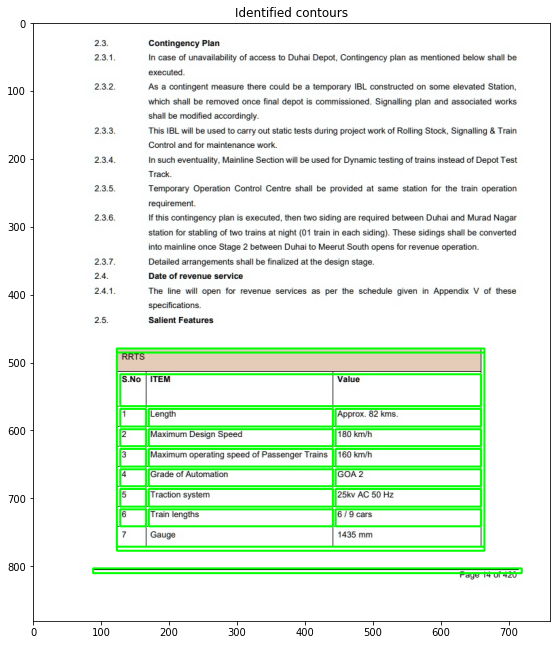

In [81]:
boxes = []
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  if (w<1000 and h<500):
    image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    boxes.append([x,y,w,h])

plt.figure(figsize=(15,11))
plotting = plt.imshow(image,cmap='gray')
plt.title("Identified contours")
plt.show()

## Getting the rows and columns

#### To store rows and columns :
  * Now we add rows and columns.
  * We calculate the mean height of all boxes.
  * Initially, we append the first box to the columns list.
  * The columns list is essentialy a temporary list.
  * We assign previous box to the first box as well.
  * We will loop through the remaining boundingBoxes list.
  * At each iteration, we check if the y coordinate of the top left corner of the current box is less than the y coordinate of the previous box added with half the mean of all heights.
  * If yes :
    * The current box is appended to columns list.
    * The current box is assigned to previous box.
    * Next we check if we are at the last index.    
        * If yes :We append the entire column to rows list.
  * If no :
    * We append the columns list to rows.
    * We assign the columns list to empty as this will start a new empty columns list.
    * We assign the current box to the previous box variable.
    * We append the current box to the empty column list we just created.

In [114]:
boundingBoxes

((0, 0, 761, 881),
 (123, 479, 541, 6),
 (123, 485, 541, 286),
 (128, 517, 531, 47),
 (445, 568, 214, 26),
 (170, 568, 271, 26),
 (128, 568, 38, 26),
 (445, 598, 214, 25),
 (170, 598, 271, 25),
 (128, 598, 38, 25),
 (445, 627, 214, 26),
 (170, 627, 271, 26),
 (128, 627, 38, 26),
 (445, 657, 214, 25),
 (170, 657, 271, 25),
 (128, 657, 38, 25),
 (445, 686, 214, 26),
 (170, 686, 271, 26),
 (128, 686, 38, 26),
 (445, 716, 214, 25),
 (170, 716, 271, 25),
 (128, 716, 38, 25),
 (123, 771, 541, 6),
 (88, 803, 631, 7))

In [115]:
len(boundingBoxes)

24

In [117]:
boundingBoxes[0][3]

881

In [126]:
np.mean([boundingBoxes[i][3] for i in range(len(boundingBoxes))])

70.5

In [127]:
boxes[0]

[123, 479, 541, 6]

In [92]:
rows=[]
columns=[]
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
print(mean)
columns.append(boxes[0])
previous=boxes[0]
for i in range(1,len(boxes)):
  if(boxes[i][1]<=previous[1]+mean/2):
    columns.append(boxes[i])
    previous=boxes[i]
    if(i==len(boxes)-1):
      rows.append(columns)
  else:
    rows.append(columns)
    columns=[]
    previous = boxes[i]
    columns.append(boxes[i])
print("Rows")
for row in rows:
  print(row)

70.5
Rows
[[123, 479, 541, 6], [123, 485, 541, 286], [128, 517, 531, 47]]
[[445, 568, 214, 26], [170, 568, 271, 26], [128, 568, 38, 26], [445, 598, 214, 25], [170, 598, 271, 25], [128, 598, 38, 25], [445, 627, 214, 26], [170, 627, 271, 26], [128, 627, 38, 26], [445, 657, 214, 25], [170, 657, 271, 25], [128, 657, 38, 25], [445, 686, 214, 26], [170, 686, 271, 26], [128, 686, 38, 26], [445, 716, 214, 25], [170, 716, 271, 25], [128, 716, 38, 25]]
[[123, 771, 541, 6], [88, 803, 631, 7]]


In [130]:
total_cells=0
for i in range(len(row)):
  if len(row[i]) > total_cells:
    total_cells = len(row[i])
print(total_cells)

4


## Retrieve the centre of cell
We add the width of cell to left bottom x coordinate to the the x coordinate of centre of cell.

In [131]:
center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]
print(list(set(center)))
center

[552, 305, 147]


[552,
 305,
 147,
 552,
 305,
 147,
 552,
 305,
 147,
 552,
 305,
 147,
 552,
 305,
 147,
 552,
 305,
 147]

In [134]:
center=np.array(center)
center.sort()
print(center)

[147 147 147 147 147 147 305 305 305 305 305 305 552 552 552 552 552 552]


In [136]:
boxes_list = []
for i in range(len(rows)):
    l=[]
    for k in range(24):
        l.append([])
    for j in range(len(rows[i])):
        diff = abs(center-(rows[i][j][0]+rows[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        l[indexing].append(rows[i][j])
    boxes_list.append(l)
for box in boxes_list:
  print(box)

[[], [], [], [], [], [], [[123, 479, 541, 6], [123, 485, 541, 286], [128, 517, 531, 47]], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[[[128, 568, 38, 26], [128, 598, 38, 25], [128, 627, 38, 26], [128, 657, 38, 25], [128, 686, 38, 26], [128, 716, 38, 25]], [], [], [], [], [], [[170, 568, 271, 26], [170, 598, 271, 25], [170, 627, 271, 26], [170, 657, 271, 25], [170, 686, 271, 26], [170, 716, 271, 25]], [], [], [], [], [], [[445, 568, 214, 26], [445, 598, 214, 25], [445, 627, 214, 26], [445, 657, 214, 25], [445, 686, 214, 26], [445, 716, 214, 25]], [], [], [], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [[123, 771, 541, 6], [88, 803, 631, 7]], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


## Extract image from the boxes and get the contents using pytesseract
We extract the region of interest from the image.
For the cell we resize it, then perform morphological operations on the extracted cell area to remove noise.
Finally, we use pytesseract to convert the image to a string.
We append the strings in each row first to temporary string s with spaces, and then we append this temporary string to the final dataframe.

In [105]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 79 not upgraded.


In [137]:
pytesseract.pytesseract.tesseract_cmd = ( r'/usr/bin/tesseract' )
dataframe_final=[]
for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        s=''
        if(len(boxes_list[i][j])==0):
            dataframe_final.append(' ')
        else:
            for k in range(len(boxes_list[i][j])):
                y,x,w,h = boxes_list[i][j][k][0],boxes_list[i][j][k][1], boxes_list[i][j][k][2],boxes_list[i][j][k][3]
                roi = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2) 
                              
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion,lang='eng',config ='-c tessedit_char_whitelist=0123456789 --psm 10 --oem 2')
                s = s +" "+ out
            dataframe_final.append(s)
print(dataframe_final)

[' ', ' ', ' ', ' ', ' ', ' ', ' \x0c | RRTS\n\nS.No JITEM Value\n\n[* [een Pr kes.\n[2 [Maximum Design Speed STROM\n[3 [Maximum operating speed of Passenger Trains [160kmn\n[# [rade of Automation GOA2\n[5 [Frection system Pak AC SH\n[> Ptraintengss cars\n\x0c S.No JITEM Value\n\x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' \x0c \x0c \x0c \x0c \x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' Length\n\x0c Maximum Design Speed\n\x0c Maximum operating speed of Passenger Trains\n\x0c Grade of Automation\n\x0c Traction system\n\x0c Train lengths\n\x0c', ' ', ' ', ' ', ' ', ' ', ' Approx. 82 kms.\n\x0c 180 km/h\n\x0c 160 km/h\n\x0c GOA 2\n\x0c 25kv AC 50 Hz\n\x0c 6/9 cars\n\x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  \n\x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [138]:
arr = np.array(dataframe_final)
arr

array([' ', ' ', ' ', ' ', ' ', ' ',
       ' \x0c | RRTS\n\nS.No JITEM Value\n\n[* [een Pr kes.\n[2 [Maximum Design Speed STROM\n[3 [Maximum operating speed of Passenger Trains [160kmn\n[# [rade of Automation GOA2\n[5 [Frection system Pak AC SH\n[> Ptraintengss cars\n\x0c S.No JITEM Value\n\x0c',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' \x0c \x0c \x0c \x0c \x0c \x0c', ' ', ' ',
       ' ', ' ', ' ',
       ' Length\n\x0c Maximum Design Speed\n\x0c Maximum operating speed of Passenger Trains\n\x0c Grade of Automation\n\x0c Traction system\n\x0c Train lengths\n\x0c',
       ' ', ' ', ' ', ' ', ' ',
       ' Approx. 82 kms.\n\x0c 180 km/h\n\x0c 160 km/h\n\x0c GOA 2\n\x0c 25kv AC 50 Hz\n\x0c 6/9 cars\n\x0c',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', '  \n\x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
      dtype='<U2

In [139]:
arr.shape

(72,)

## Creating a dataframe from extracted data

* We reshape our array into a dataframe with the number of rows and columns.


In [140]:
total_cells

4

In [142]:
import pandas as pd
dataframe = pd.DataFrame(arr.reshape(24, 3))
data = dataframe.style.set_properties(align="left")
print(data)
print(dataframe)
d=[]
for i in range(0,len(rows)):
  for j in range(0,total_cells):
    print(dataframe[i][j],end=" ")
  print()

                                                    0  1  2
0                                                          
1                                                          
2     | RRTS\n\nS.No JITEM Value\n\n[* [een Pr ke...      
3                                                          
4                                                          
5                                                          
6                                                          
7                                                          
8                                                    
9                                                          
10   Length\n Maximum Design Speed\n Maximum ope...      
11                                                         
12   Approx. 82 kms.\n 180 km/h\n 160 km/h\n GO...      
13                                                         
14                                                         
15                                      

In [144]:

print(dataframe)

                                                    0  1  2
0                                                          
1                                                          
2     | RRTS\n\nS.No JITEM Value\n\n[* [een Pr ke...      
3                                                          
4                                                          
5                                                          
6                                                          
7                                                          
8                                                    
9                                                          
10   Length\n Maximum Design Speed\n Maximum ope...      
11                                                         
12   Approx. 82 kms.\n 180 km/h\n 160 km/h\n GO...      
13                                                         
14                                                         
15                                      